In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from matplotlib import cm

# device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#Dynamics functions
f = lambda x: 0.7
sigma = lambda x: 1.0

class TanhFixedPointLayer(nn.Module):
    def __init__(self, out_features, tol=1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter

    def forward(self, x):
        # initialize output z to be zero
        z = torch.zeros_like(x)
        self.iterations = 0

        # iterate until convergence
        while self.iterations < self.max_iter:
            z_next = torch.tanh(self.linear(z) + x)
            self.err = torch.norm(z - z_next)
            z = z_next
            self.iterations += 1
            if self.err < self.tol:
                break

        return z


class TanhNewtonImplicitLayer(nn.Module):
    def __init__(self, out_features, tol=1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter

    def forward(self, x):
        # Run Newton's method outside of the autograd framework
        with torch.no_grad():
            z = torch.tanh(x)
            self.iterations = 0
            while self.iterations < self.max_iter:
                z_linear = self.linear(z) + x
                g = z - torch.tanh(z_linear)
                self.err = torch.norm(g)
                if self.err < self.tol:
                    break

                # newton step
                J = torch.eye(z.shape[1])[None, :, :].to(device) - (1 / torch.cosh(z_linear) ** 2)[:, :,
                                                        None] * self.linear.weight[None, :, :]
                z = z - torch.linalg.solve(J, g[:, :, None])[:, :, 0]
                self.iterations += 1

        # reengage autograd and add the gradient hook
        z = torch.tanh(self.linear(z) + x)
        z.register_hook(lambda grad: torch.linalg.solve(J.transpose(1, 2), grad[:, :, None])[:, :, 0])
        return z

def physics_loss(model, x, T):
    # Define your physics-informed loss function
    x.requires_grad_(True)
    T.requires_grad_(True)
    u = model(x, T)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_T = torch.autograd.grad(u, T, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    loss_pde = torch.mean((u_T - 0.5*((sigma(x))**2)*u_xx - f(x)*u_x)**2) # PDE loss
    return  0.5 * 10000 * loss_pde # multiplied by 10000 so that physics and boundary losses are comparable

def boundary_loss(model, x, T, F):
    # x.requires_grad_(True)
    # T.requires_grad_(True)
    u = model(x, T)
    loss_boundary = 0.5 * torch.mean((u - F) ** 2)  # Boundary loss may need some more weight since there is less boundary data
    return loss_boundary

# Optimizer and model instantiation
torch.manual_seed(0)

class DEQ_model(nn.Module):
    def __init__(self):
        super(DEQ_model, self).__init__()
        # Define your neural network architecture
        self.fc1 = nn.Linear(2, 50)  # Input: (x, t)
        self.implicit_layer = TanhNewtonImplicitLayer(50, max_iter=40) #50 x 50 weight matrix weight tied
        self.fc2 = nn.Linear(50, 1)   #2650 params total

    def forward(self, x, T):
        # Concatenate space and time
        input_data = torch.cat((x.unsqueeze(1), T.unsqueeze(1)), dim=1)
        # Forward pass through the network
        out = self.fc1(input_data)
        out = self.implicit_layer(out)
        out = self.fc2(out)
        return out
    
# Data loading and pre-processing

loaded_boundary_data = np.load('1_d_boundary_data.npy', allow_pickle= True)
x_T_tr_b = loaded_boundary_data[:,0]
x_T_tr_b_array = [list(i) for i in zip(*x_T_tr_b)]
x_tr_b = np.array([]) #empty array
T_tr_b = np.array([]) #empty array
F_tr_b = loaded_boundary_data[:,1]
F_tr_b = np.array(F_tr_b, dtype= float)
for state in x_T_tr_b_array[0]:
    x_tr_b = np.append(x_tr_b, state[0])
for time in x_T_tr_b_array[1]:
    T_tr_b = np.append(T_tr_b, time)

loaded_physics_data = np.load('1_d_interior_data.npy', allow_pickle=True)
x_T_tr_p = loaded_physics_data[:,0]
x_T_tr_p_array = [list(i) for i in zip(*x_T_tr_p)]
x_tr_p = np.array([]) #empty array
T_tr_p = np.array([]) #empty array
F_tr_p = loaded_physics_data[:,1]
F_tr_p = np.array(F_tr_p, dtype= float)
for state in x_T_tr_p_array[0]:
    x_tr_p = np.append(x_tr_p, state[0])
for time in x_T_tr_p_array[1]:
    T_tr_p = np.append(T_tr_p, time)

N_b = np.shape(T_tr_b)[0] # boundary data size
N_p = np.shape(T_tr_p)[0] # physics data size
# an 80-20% split of training and test data on both boundary and physics data
N_b_tr = int(N_b * 0.8)
N_p_tr = int(N_p * 0.8)
N_b_te = N_b - N_b_tr
N_p_te = N_p - N_p_tr

# # Now we shuffle all data
# boundary_indices = np.random.permutation(N_b)
# physics_indices = np.random.permutation(N_p)
# x_tr_b = x_tr_b[boundary_indices]
# T_tr_b = T_tr_b[boundary_indices]
# F_tr_b = F_tr_b[boundary_indices]
# x_tr_p = x_tr_p[physics_indices]
# T_tr_p = T_tr_p[physics_indices]
# F_tr_p = F_tr_p[physics_indices]

x_te_b = x_tr_b[N_b_tr:]
T_te_b = T_tr_b[N_b_tr:]
F_te_b = F_tr_b[N_b_tr:]
x_tr_b = x_tr_b[0:N_b_tr]
T_tr_b = T_tr_b[0:N_b_tr]
F_tr_b = F_tr_b[0:N_b_tr]

x_te_p = x_tr_p[N_p_tr:]
T_te_p = T_tr_p[N_p_tr:]
F_te_p = F_tr_p[N_p_tr:]
x_tr_p = x_tr_p[0:N_p_tr]
T_tr_p = T_tr_p[0:N_p_tr]
F_tr_p = F_tr_p[0:N_p_tr]


model = DEQ_model().to(device)
optimizer_p = optim.Adam(model.parameters(), lr=0.001)
optimizer_b = optim.Adam(model.parameters(), lr= 0.02)

# define lists for plotting
train_boundary_losses = []
train_physics_losses = []
val_boundary_losses = []
val_physics_losses = []

# Training loop
num_epochs = 25
physics_batch_size = 100
boundary_batch_size = 100
for epoch in range(num_epochs):

    l_boundary_epoch_average = 0
    l_physics_epoch_average = 0
    for i in range(0,N_b_tr,boundary_batch_size): # runs same as "for i in range(0, N_p_tr, physics_batch_size):"
        batch_x_tr_b = torch.tensor(x_tr_b[i:i+boundary_batch_size],dtype=torch.float).to(device)
        batch_T_tr_b = torch.tensor(T_tr_b[i:i+boundary_batch_size],dtype=torch.float).to(device)
        batch_F_tr_b = torch.tensor(F_tr_b[i:i+boundary_batch_size], dtype=torch.float).to(device)
        batch_x_tr_p = torch.tensor(x_tr_p[i:i + physics_batch_size], dtype=torch.float).to(device)
        batch_T_tr_p = torch.tensor(T_tr_p[i:i + physics_batch_size], dtype=torch.float).to(device)
        # Compute boundary loss
        l_b = boundary_loss(model,batch_x_tr_b,batch_T_tr_b,batch_F_tr_b)
        # Optimization step
        optimizer_b.zero_grad()
        l_b.backward()
        if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0:
            optimizer_b.step()
        # Compute physics loss
        l_p = physics_loss(model, batch_x_tr_p, batch_T_tr_p)
        # Optimization step
        optimizer_p.zero_grad()
        l_p.backward()
        if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0:
            optimizer_p.step()
        # Accumulate average loss
        l_boundary_epoch_average += l_b.item()
        l_physics_epoch_average += l_p.item()
    l_boundary_epoch_average = l_boundary_epoch_average *(1/(N_b_tr/boundary_batch_size))
    l_physics_epoch_average = l_physics_epoch_average * (1 / (N_p_tr / physics_batch_size))
    
    
    # test prediction
    model.eval()
    boundary_val_loss = boundary_loss(model, torch.tensor(x_te_b, dtype=torch.float, device=device), torch.tensor(T_te_b, dtype=torch.float, device=device), torch.tensor(F_te_b, dtype=torch.float, device=device))
    physics_val_loss = physics_loss(model, torch.tensor(x_te_p, dtype=torch.float, device=device), torch.tensor(T_te_p, dtype=torch.float, device=device))
    
    # Save the average losses for plotting
    train_boundary_losses.append(l_boundary_epoch_average)
    train_physics_losses.append(l_physics_epoch_average)
    val_boundary_losses.append(boundary_val_loss.item())
    val_physics_losses.append(physics_val_loss.item())
    
    # Print loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Boundary Loss: {l_boundary_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Physics Loss: {l_physics_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Boundary Loss: {boundary_val_loss.item():.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Physics Loss: {physics_val_loss.item():.4f}")


# fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Two subplots in one column
# predict 


   # Now we evaluate performance on test data
"""
test_physics_loss = physics_loss(model, torch.tensor(x_te_p, dtype=torch.float), torch.tensor(T_te_p, dtype=torch.float))
print(test_physics_loss)


test_boundary_loss = boundary_loss(model, torch.tensor(x_te_b, dtype=torch.float), torch.tensor(T_te_b, dtype= torch.float),
                                                        torch.tensor(F_te_b, dtype=torch.float))
print(test_boundary_loss)
"""
# figure_of_merit = torch.sqrt(2.0 * boundary_loss(model, torch.tensor(x_te_p, dtype= torch.float).to(device), torch.tensor(T_te_p, dtype= torch.float).to(device),
#                                 torch.tensor(F_te_p, dtype = torch.float).to(device)))

# print(figure_of_merit)

# # Save the model
model_path = "checkpoints/deq6.pth"
torch.save(model.state_dict(), model_path)


Epoch [1/25], Train Boundary Loss: 0.0900
Epoch [1/25], Train Physics Loss: 3.3940
Epoch [1/25], Eval Boundary Loss: 0.0787
Epoch [1/25], Eval Physics Loss: 2030.5355
Epoch [2/25], Train Boundary Loss: 0.0798
Epoch [2/25], Train Physics Loss: 152.7032
Epoch [2/25], Eval Boundary Loss: 0.0806
Epoch [2/25], Eval Physics Loss: 2.3621
Epoch [3/25], Train Boundary Loss: 0.0798
Epoch [3/25], Train Physics Loss: 0.8398
Epoch [3/25], Eval Boundary Loss: 0.0872
Epoch [3/25], Eval Physics Loss: 2.7191
Epoch [4/25], Train Boundary Loss: 0.0795
Epoch [4/25], Train Physics Loss: 0.6193
Epoch [4/25], Eval Boundary Loss: 0.0787
Epoch [4/25], Eval Physics Loss: 0.7838
Epoch [5/25], Train Boundary Loss: 0.0791
Epoch [5/25], Train Physics Loss: 0.4893
Epoch [5/25], Eval Boundary Loss: 0.0794
Epoch [5/25], Eval Physics Loss: 0.6828
Epoch [6/25], Train Boundary Loss: 0.0792
Epoch [6/25], Train Physics Loss: 0.4685
Epoch [6/25], Eval Boundary Loss: 0.0797
Epoch [6/25], Eval Physics Loss: 0.5640
Epoch [7/25

In [2]:
# baseline model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Define your neural network architecture
        self.fc1 = nn.Linear(2, 50)  # Input: (x, t)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)  # Output: temperature

    def forward(self, x, T):
        # Concatenate space and time
        input_data = torch.cat((x.unsqueeze(1), T.unsqueeze(1)), dim=1)
        input_data = input_data.to(device)
        # Forward pass through the network
        out = torch.tanh(self.fc1(input_data))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out
    
# Optimizer and model instantiation

model_base = PINN().to(device)
optimizer_p_base = optim.Adam(model_base.parameters(), lr=0.01)
optimizer_b_base = optim.Adam(model_base.parameters(), lr= 0.002)

# define lists for plotting
train_boundary_losses_base = []
train_physics_losses_base = []
val_boundary_losses_base = []
val_physics_losses_base = []
for epoch in range(num_epochs):

    l_boundary_epoch_average = 0
    l_physics_epoch_average = 0
    for i in range(0,N_b_tr,boundary_batch_size): # runs same as "for i in range(0, N_p_tr, physics_batch_size):"
        batch_x_tr_b = torch.tensor(x_tr_b[i:i+boundary_batch_size],dtype=torch.float)
        batch_T_tr_b = torch.tensor(T_tr_b[i:i+boundary_batch_size],dtype=torch.float)
        batch_F_tr_b = torch.tensor(F_tr_b[i:i+boundary_batch_size], dtype=torch.float)
        batch_x_tr_p = torch.tensor(x_tr_p[i:i + physics_batch_size], dtype=torch.float)
        batch_T_tr_p = torch.tensor(T_tr_p[i:i + physics_batch_size], dtype=torch.float)
        # Compute boundary loss
        l_b = boundary_loss(model_base,batch_x_tr_b,batch_T_tr_b,batch_F_tr_b)
        # Optimization step
        optimizer_b_base.zero_grad()
        l_b.backward()
        optimizer_b_base.step()
        # Compute physics loss
        l_p = physics_loss(model_base, batch_x_tr_p, batch_T_tr_p)
        # Optimization step
        optimizer_p_base.zero_grad()
        l_p.backward()
        optimizer_p.step()
        # Accumulate average loss
        l_boundary_epoch_average += l_b.item()
        l_physics_epoch_average += l_p.item()
    l_boundary_epoch_average = l_boundary_epoch_average *(1/(N_b_tr/boundary_batch_size))
    l_physics_epoch_average = l_physics_epoch_average * (1 / (N_p_tr / physics_batch_size))
    
    # test prediction
    model.eval()
    boundary_val_loss = boundary_loss(model_base, torch.tensor(x_te_b, dtype=torch.float, device=device), torch.tensor(T_te_b, dtype=torch.float, device=device), torch.tensor(F_te_b, dtype=torch.float, device=device))
    physics_val_loss = physics_loss(model_base, torch.tensor(x_te_p, dtype=torch.float, device=device), torch.tensor(T_te_p, dtype=torch.float, device=device))
    # Save the average losses for plotting
    train_boundary_losses_base.append(l_boundary_epoch_average)
    train_physics_losses_base.append(l_physics_epoch_average)
    val_boundary_losses_base.append(boundary_val_loss.item())
    val_physics_losses_base.append(physics_val_loss.item())
    
    # Print loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Boundary Loss: {l_boundary_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Physics Loss: {l_physics_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Boundary Loss: {boundary_val_loss.item():.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Physics Loss: {physics_val_loss.item():.4f}")

# # Save the model
model_path = "checkpoints/pipe.pth"
torch.save(model_base.state_dict(), model_path)

Epoch [1/25], Boundary Loss: 0.0798
Epoch [1/25], Physics Loss: 0.3351
Epoch [1/25], Eval Boundary Loss: 0.0789
Epoch [1/25], Eval Physics Loss: 0.3303
Epoch [2/25], Boundary Loss: 0.0786
Epoch [2/25], Physics Loss: 0.0708
Epoch [2/25], Eval Boundary Loss: 0.0784
Epoch [2/25], Eval Physics Loss: 0.1524
Epoch [3/25], Boundary Loss: 0.0785
Epoch [3/25], Physics Loss: 0.0438
Epoch [3/25], Eval Boundary Loss: 0.0784
Epoch [3/25], Eval Physics Loss: 0.1081
Epoch [4/25], Boundary Loss: 0.0785
Epoch [4/25], Physics Loss: 0.0269
Epoch [4/25], Eval Boundary Loss: 0.0782
Epoch [4/25], Eval Physics Loss: 0.0583
Epoch [5/25], Boundary Loss: 0.0785
Epoch [5/25], Physics Loss: 0.0299
Epoch [5/25], Eval Boundary Loss: 0.0780
Epoch [5/25], Eval Physics Loss: 0.0267
Epoch [6/25], Boundary Loss: 0.0785
Epoch [6/25], Physics Loss: 0.0157
Epoch [6/25], Eval Boundary Loss: 0.0779
Epoch [6/25], Eval Physics Loss: 0.0180
Epoch [7/25], Boundary Loss: 0.0785
Epoch [7/25], Physics Loss: 0.0189
Epoch [7/25], Eva

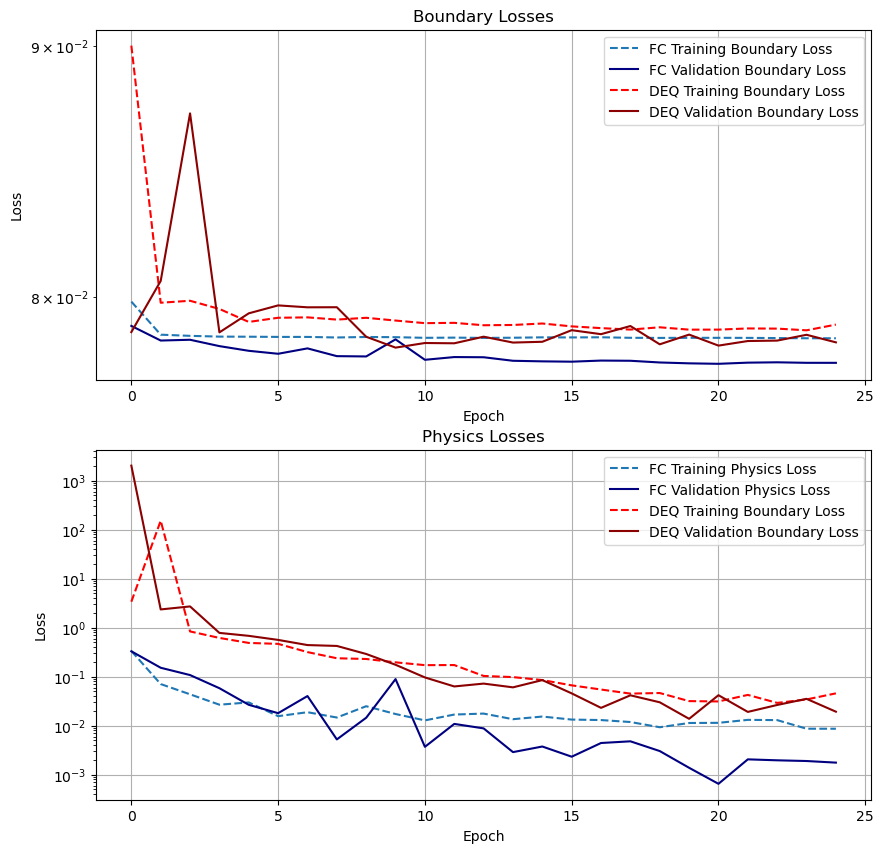

In [3]:
# Prepare the plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Two subplots in one column

# Plot for boundary losses
axs[0].plot(train_boundary_losses_base, label='FC Training Boundary Loss', linestyle='--', color='tab:blue')
axs[0].plot(val_boundary_losses_base, label='FC Validation Boundary Loss', linestyle='-', color='navy')
axs[0].plot(train_boundary_losses, label='DEQ Training Boundary Loss', linestyle='--', color='red')
axs[0].plot(val_boundary_losses, label='DEQ Validation Boundary Loss', linestyle='-', color='darkred')
axs[0].set_title('Boundary Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_yscale('log')
# axs[0].set_ylim(1e-5, 1e0)  # Set fixed log scale range
axs[0].legend()
axs[0].grid(True)

# Plot for physics losses
axs[1].plot(train_physics_losses_base, label='FC Training Physics Loss', linestyle='--', color='tab:blue')
axs[1].plot(val_physics_losses_base, label='FC Validation Physics Loss', linestyle='-', color='navy')
axs[1].plot(train_physics_losses, label='DEQ Training Boundary Loss', linestyle='--', color='red')
axs[1].plot(val_physics_losses, label='DEQ Validation Boundary Loss', linestyle='-', color='darkred')
axs[1].set_title('Physics Losses')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True)

# Save the plot
plot_path = "plots/loss_all.png"
plt.savefig(plot_path)
plt.show()

In [4]:
# check parameter
deq_params = sum(p.numel() for p in model.parameters())
fc_params = sum(p.numel() for p in model_base.parameters())
print(f"DEQ model has {deq_params} parameters, FC model has {fc_params} parameters")

DEQ model has 2701 parameters, FC model has 7851 parameters


In [6]:
import numpy as np

import numpy.random as npr

# def wiener1(dt=0.1,X0=X(t=0),Nt=1000):
#     """ Input variables:
#     dt    time step
#     X0    intial value, X(t=0) = X0
#     Nt    number of time steps
#     """
#     # initialize start value
#     res = X0
#     # calculate and store time series
#     for ii in range(1,Nt):
#         #         X(t+dt)=X(t)+sqrt(dt)*npr.randn(Nt)
#         res += sqrt(dt)*npr.randn(Nt)
#
#     # return final value after t = N*dt
#     return res



dx = 0.4
dT = 0.5
T_max = 10
T_min = 0

def dynamics_runner(x_0, f, sigma, T_max):
    dim = np.shape(x_0)[0]
    noise_dim = np.shape(sigma(x_0))[1]
    horizon = int(np.ceil(T_max/dT))
    traj = np.zeros((horizon+1,dim))
    x_h = x_0
    recovered = False
    for h in range(horizon+1):
        traj[h,:] = x_h
        dw_h = np.sqrt(dT)*npr.randn(noise_dim)
        x_h = f(x_h) * dT + np.dot(sigma(x_h), dw_h)
        if (x_h >= 2.0):
            recovered = True
    return traj, recovered

def sample_from_box(low, high, size=(1,)):
    """
    Generate random vectors uniformly from a box defined by low and high values.

    Parameters:
        low: array_like
            Lower bounds of the box.
        high: array_like
            Upper bounds of the box.
        size: int or tuple of ints, optional
            Output shape. If the given shape is, e.g., (m, n, k),
            then m * n * k samples are drawn. Default is (1,).

    Returns:
        ndarray
            Random vectors sampled from the box.
    """
    low = np.asarray(low)
    high = np.asarray(high)
    return np.random.uniform(low=low, high=high, size=size)


def MC_sampler_grid(x_span, t_span): #number of trajectories required is N_P x N_T
    MC_samples_dict = {}# dictionary to store the map F(x,T) at samples
    # Set of interest is Omega x tau = [-10,2] x [0,10] and safety for x \geq 2 i.e., \phi(x) = x-2
    # sampling dx=0.4, dT =0.5. We want to estimate the recovery probability
    low = np.array([-10])  # Lower bounds of the box
    high = np.array([2])  # Upper bounds of the box
    sample_size = (N_P, 1)  # Sample size (5 vectors of dimension 1)
    vectors = np.linspace(-9.8,2,60)
    Ts = np.linspace(0.1,10,100)
    for v in vectors:
        for T in Ts:
            recovery_count = 0
            for s in range(10): # 10 MC samples per trajectory input (x,T)
                traj, recovery = dynamics_runner(v,f,sigma,T) #run trajectory upto time T
                if(recovery):
                    recovery_count += 1
                # MC_samples_data.append(traj)
            F_v_T = recovery_count/10
            MC_samples_dict[tuple(v),T] = F_v_T
    sample_data = np.array(list(MC_samples_dict.items()), dtype=object)
    return sample_data

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example arrays - replace these with your actual data
X = np.random.normal(size=100)  # Your X-array
Y = np.random.normal(size=100)  # Your Y-array
Z = np.random.normal(size=100)  # Your Z-array

# Create a regular grid to interpolate the data.
xi = np.linspace(min(X), max(X), 100)
yi = np.linspace(min(Y), max(Y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((X, Y), Z, (xi, yi), method='linear')

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap=plt.cm.coolwarm)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Surface Plot from 3D Point Cloud')
plt.show()


Text(0.5, 0.92, 'PIPE Error ($N=10$)')

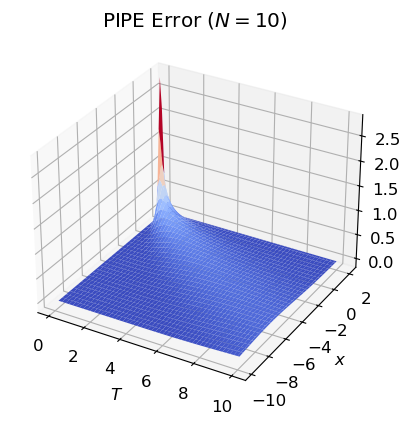

In [120]:


t = np.linspace(0.1,10,100) # time
x = np.linspace(-9.8,2,60) # position
# analytical analysis given X, T

X, T = np.meshgrid(x, t)

def analytical_sol(X, T):
    F = (2-X)*np.exp(-((2-X)-0.7*T)**2/(2*T))/np.sqrt(2*np.pi*T**3)
    return F

F = analytical_sol(X, T)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(T, X, F, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error ($N=10$)")

## Grid results

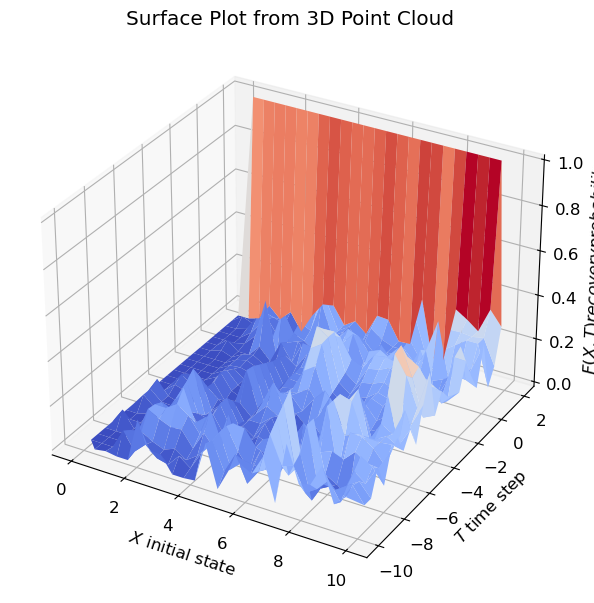

In [54]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example arrays - replace these with your actual data
Y_b = x_te_b
X_b = T_te_b
F_test_b = F_te_b
F_FC_b = model_base(torch.tensor(x_te_b, dtype=torch.float, device=device), torch.tensor(T_te_b, dtype=torch.float, device=device)).detach().numpy().reshape(-1)
F_DEQ_b = model(torch.tensor(x_te_b, dtype=torch.float, device=device), torch.tensor(T_te_b, dtype=torch.float, device=device)).detach().numpy().reshape(-1)

Y_p = x_te_p
X_p = T_te_p
F_test_p = F_te_p
F_FC_p = model_base(torch.tensor(x_te_p, dtype=torch.float, device=device), torch.tensor(T_te_p, dtype=torch.float, device=device)).detach().numpy().reshape(-1)
F_DEQ_p = model(torch.tensor(x_te_p, dtype=torch.float, device=device), torch.tensor(T_te_p, dtype=torch.float, device=device)).detach().numpy().reshape(-1)

X = np.concatenate((X_b, X_p))
Y = np.concatenate((Y_b, Y_p))
F_test = np.concatenate((F_test_b, F_test_p))
F_FC = np.concatenate((F_FC_b, F_FC_p))
F_DEQ = np.concatenate((F_DEQ_b, F_DEQ_p))


# Create a regular grid to interpolate the data.
xi = np.linspace(min(X),max(X),25) # time 
yi = np.linspace(min(Y),max(Y),25) # state
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((X, Y), F_test, (xi, yi), method='linear')

# Create the plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap=plt.cm.coolwarm)

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('$X$ initial state')
ax.set_ylabel('$T$ time step')
ax.set_zlabel('$F(X,T)$')
ax.set_title("Recovery Probability")
ax.dist = 12
# Use tight layout with pad
plt.tight_layout(pad=3.0)

plt.title('Surface Plot from 3D Point Cloud')
# Adjust the subplot margins
plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)
plt.show()


In [47]:
x2 = np.concatenate((x_tr_p,x_tr_p))
x2.shape

(16000,)

In [45]:
x_tr_b.shape

(8000,)

8000